# CI HW2

## Q1

The CPLEX solver has been used to solve the linear programming problem. Per *Tanaka and Watada, 1988*, the objective has been identified as the sum of all spreads (c) at each observation. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

ar = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], # intercept
               [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3], # x
               [1, 3, 1, 2, 4, 3, 4, 5, 2, 5, 6]]) # y
X_lp = ar[[0, 1], :].T
X_lp.shape
y_lp = ar[2].T
y_lp.shape

# Test 1, sum of all c's at each obs
# Define threshold. Higher the h, wider the spread
h = 0.5
# Define and solve the CVXPY problem.
c = cp.Variable(X_lp.shape[1])  # for spread variables
alpha = cp.Variable(X_lp.shape[1])  # for center/core variables
cost = cp.sum(X_lp * c)  # define cost function
obj = cp.Minimize(cost)  # define objective function
constraints = [c >= 0,
               y_lp <= (1 - h) * abs(X_lp) * c + X_lp * alpha,  # abs operate on each elements of X_lp
               -y_lp <= (1 - h) * abs(X_lp) * c - X_lp * alpha]

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.CPLEX, verbose=True)
print("status:", prob.status)
print("\nThe optimal value is", prob.value)  # print optimal value
print("\nThe predictor center is", alpha.value[1:X_lp.shape[1]],
      "\nThe Intercept center is", alpha.value[0])
print("\nThe predictor spread is", c.value[1:X_lp.shape[1]],
      "\nThe Intercept spread is", c.value[0])

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 16 rows and 0 columns.
Reduced LP has 8 rows, 4 columns, and 28 nonzeros.
Presolve time = 0.00 sec. (0.02 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
status: optimal

The optimal value is 36.5

The predictor center is [0.75] 
The Intercept center is 1.7500000000000002

The predictor spread is [0.5] 
The Intercept spread is 2.4999999999999996


Also per *Tanaka et al., 1982*, the objective function of sum of predictors' spread was tried out. In fact both objective functions gives the same result as of the predictor center and the spread. 

In [2]:
# Test 2, sum of c's
# Define threshold. Higher the h, wider the spread
h = 0.5
# Define and solve the CVXPY problem.
c = cp.Variable(X_lp.shape[1])  # for spread variables
alpha = cp.Variable(X_lp.shape[1])  # for center/core variables
cost = cp.sum(c)  # define cost function
obj = cp.Minimize(cost)  # define objective function
constraints = [c >= 0,
               y_lp <= (1 - h) * abs(X_lp) * c + X_lp * alpha,  # abs operate on each elements of X_lp
               -y_lp <= (1 - h) * abs(X_lp) * c - X_lp * alpha]

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.CPLEX, verbose=True)
print("status:", prob.status)
print("\nThe optimal value is", prob.value)  # print optimal value
print("\nThe predictor center is", alpha.value[1:X_lp.shape[1]],
      "\nThe Intercept center is", alpha.value[0])
print("\nThe predictor spread is", c.value[1:X_lp.shape[1]],
      "\nThe Intercept spread is", c.value[0])

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 16 rows and 0 columns.
Reduced LP has 8 rows, 4 columns, and 28 nonzeros.
Presolve time = 0.00 sec. (0.02 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
status: optimal

The optimal value is 3.0

The predictor center is [0.75] 
The Intercept center is 1.7500000000000002

The predictor spread is [0.5] 
The Intercept spread is 2.4999999999999996


## Q2

Take the model I was using for the 30-sec jump rope count forecast in HW1. Below is the linear regression part along with the forecast result. The predicted weekly record using Linear regression is: `132.02`. 

In [3]:
### Linear regression:
# Prepare for the training data
rope = pd.read_excel('data/HW1 Data.xlsx')
rope = rope.drop(columns=['Name'])
rope = rope.fillna(0)
# Date preprocessing
rope = rope.loc[rope['Weight'] != 1].drop(columns=['Weight'])  # remove Weight=1 rows
rope['week_num'] = rope['Timestamp'].dt.week  # add week of year col
rope['weekday'] = rope['Timestamp'].dt.dayofweek  # add weekday col
rope['weekend'] = (rope['weekday'] > 4).astype(float).map({1: 'Yes', 0: 'No'})  # add weekend indicator col
rope['DOY'] = rope['Timestamp'].dt.dayofyear  # add day of year col
rope['weekly_max'] = rope.groupby(['Subject', 'week_num'])['Count'].transform(max)
rope['daily_max'] = rope.groupby(['Subject', 'DOY'])['Count'].transform(max)
# Subset rows only when count=daily_max
rope = rope.loc[rope['Count'] == rope['daily_max']]
rope_30 = rope.loc[rope['Subject'] == '30 seconds'].drop(columns=['Subject'])
rope_30 = rope_30.loc[rope_30['DOY'] > 200] # choose only DOY>200 data

import macros as mac
import statsmodels.formula.api as smf
rope_30 = mac.add_trend(rope_30)  # add trend and logtrend
res_30 = smf.ols(formula='daily_max ~ logtrend + C(weekend)', data=rope_30).fit()
fcst_30 = mac.forecastset(ip=rope_30)  # forecast dataset for 30 secs
pred_30 = res_30.predict(fcst_30)  # predict on test set

print(res_30.params)
print('The predicted weekly record using Linear regression is:', max(pred_30))

Intercept            122.790936
C(weekend)[T.Yes]      1.707586
logtrend               2.308767
dtype: float64
The predicted weekly record using Linear regression is: 132.020707449649


Implement the fuzzy regression model and use the solver to solve the linear programming problem. The two predicters are `weekend indicator` and `logtrend`. The estimated center along with the spread is calculated as below. The forecast using Fuzzy regression is: `129.65`.

In [4]:
### Fuzzy regression
from patsy import dmatrix

levels = rope_30.weekend
categorical = dmatrix("levels", rope_30.weekend)

X_lp = np.hstack((np.array(categorical[:, 0])[np.newaxis].T,  # categorical[:, 0] intercept, T is transform
                  np.array(categorical[:, 1])[np.newaxis].T,  # categorical[:, 1] weekend indicator
                  np.array(rope_30.logtrend)[np.newaxis].T))
y_lp = np.array(rope_30.daily_max, dtype=np.float32)
# Define threshold. Higher the h, wider the spread
h = 0.5
c = cp.Variable(X_lp.shape[1])  # for spread variables
alpha = cp.Variable(X_lp.shape[1])  # for center/core variables
cost = cp.sum(c)  # define cost function
obj = cp.Minimize(cost)  # define objective function
constraints = [c >= 0,
               y_lp <= (1 - h) * abs(X_lp) * c + X_lp * alpha,  # abs operate on each elements of X_lp
               -y_lp <= (1 - h) * abs(X_lp) * c - X_lp * alpha]

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.CPLEX)
print("status:", prob.status)
print("\nThe optimal value is", prob.value)  # print optimal value
print("\nThe predictor center is", alpha.value[1:X_lp.shape[1]], # [weekend, logtrend]
      "\nThe Intercept center is", alpha.value[0])
print("\nThe predictor spread is", c.value[1:X_lp.shape[1]],
      "\nThe Intercept spread is", c.value[0])

### Predict using fuzzy regression model, intercept+
fuzz_fcst_30 = fcst_30[['weekend', 'logtrend']].replace({'Yes': 1, 'No': 0}) # replace Yes with 1
fuzz_pred_30=alpha.value[0]+(alpha.value[1:X_lp.shape[1]] * fuzz_fcst_30).sum(axis=1)
print('The predicted weekly record using Fuzzy regression is:', max(fuzz_pred_30))

status: optimal

The optimal value is 6.276133944081227

The predictor center is [4.48158605 0.81606153] 
The Intercept center is 122.51841395113134

The predictor spread is [0.         6.27613394] 
The Intercept spread is 0.0
The predicted weekly record using Fuzzy regression is: 129.6588072535701


## Q3

See attached worksheet HW2 Q3.xlsx

## Q4

### K-means

First I implement K-means to cluster Leo's performances. I created a one-dimensional problem by considering the more count of jump ropes (sum of all 3 subjects) each day, the higher productive day it will be. 

For the weight training period during 4/6-4/24, I calculate the average performance for each subject and compare to the rest of the data set (where weight != 1). The ratio_30, ratio_1 and ratio_3 store the ratio of average performance under weight training vs. non-weight training, for 30-second, 1-min and 3-min subject respectively. 

Then the weight training observations are adjusted accordingly based on these ratios. This is to interpolate the performances if Leo is under non-weight trainings during these days. 

In [5]:
import matplotlib.pyplot as plt

rope = pd.read_excel('data/HW1 Data.xlsx')
rope = rope.drop(columns=['Name'])
rope = rope.fillna(0)

## Calculate non-weight vs. weight ratio based on the average value under each subject.
weight30 = rope[(rope['Weight'] == 1) & (rope['Subject'] == '30 seconds')]  # Weight is 1: 4/6-4/24
rope_30 = rope.loc[rope['Subject'] == '30 seconds'].drop(columns=['Subject'])
ratio_30 = np.mean(rope_30.Count) / np.mean(weight30.Count)

weight1 = rope[(rope['Weight'] == 1) & (rope['Subject'] == '1 minute')]  # Weight is 1: 4/6-4/24
rope_1 = rope.loc[rope['Subject'] == '1 minute'].drop(columns=['Subject'])
ratio_1 = np.mean(rope_1.Count) / np.mean(weight1.Count)

weight3 = rope[(rope['Weight'] == 1) & (rope['Subject'] == '3 minutes')]  # Weight is 1: 4/6-4/24
rope_3 = rope.loc[rope['Subject'] == '3 minutes'].drop(columns=['Subject'])
ratio_3 = np.mean(rope_3.Count) / np.mean(weight3.Count)

## Transform the weighted days data using the ratios and make the adjusted count
rope.loc[(rope['Weight'] == 1) & (rope['Subject'] == '30 seconds'), 'Count'] = rope['Count'] * ratio_30
rope.loc[(rope['Weight'] == 1) & (rope['Subject'] == '1 minute'), 'Count'] = rope['Count'] * ratio_1
rope.loc[(rope['Weight'] == 1) & (rope['Subject'] == '3 minutes'), 'Count'] = rope['Count'] * ratio_3

The following implement the K-means method while setting k=2. The cluster membership is drawn for each date. We can see majority of the days are within **Cluster 1 (non-productive)** and some are under the **Cluster 2 (productive)**. 

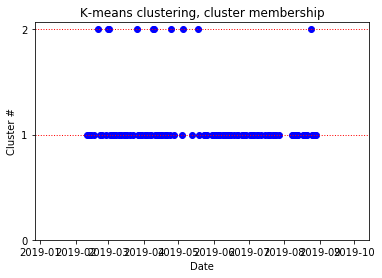

In [6]:
## Consider it to be a one-dimensional problem.
## Cluster the productivity via the total amount of jump rope
rope['week_num'] = rope['Timestamp'].dt.week  # add week of year col
rope['weekday'] = rope['Timestamp'].dt.dayofweek  # add weekday col
rope['weekend'] = (rope['weekday'] > 4).astype(float).map({1: 'Yes', 0: 'No'})  # add weekend indicator col
rope['DOY'] = rope['Timestamp'].dt.dayofyear  # add day of year col
daily_sum = rope.groupby(['DOY'], as_index=False).sum()  # group by DOY and sum, no index specified

from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

counts = daily_sum['Count'].to_numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=2).fit(counts)  # store the model, k=2
cluster = kmeans.predict(counts)  # predict to itself, result stored in cluster
## cluster result
result = pd.concat([daily_sum, pd.Series(cluster, name='cluster')], axis=1)

## convert DOY to date
result['Date'] = datetime(2019, 1, 1) + result['DOY'].map(timedelta) - timedelta(days=1)
result['cluster'] = result['cluster'] + 1 # make to be cluster 1 and 2
## Visualize the date clusters
plt.scatter('Date', 'cluster', data=result, c='blue')
plt.yticks(np.arange(0, 3, 1))
plt.axhline(y=1, color='red', linestyle=':', linewidth=1)
plt.axhline(y=2, color='red', linestyle=':', linewidth=1)
plt.title('K-means clustering, cluster membership')
plt.xlabel('Date')
plt.ylabel('Cluster #')
plt.show()

Also the Daily Count at each day has been plotted and the red dots belong to **Cluster 1 (non-productive)** and the blue dots are under the **Cluster 2 (productive)**. The cluster center are shown as below. 

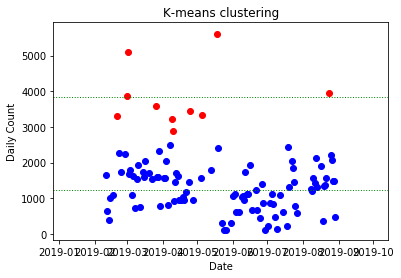

Cluster 1 center is:  [1246.66049086]
Cluster 2 center is:  [3834.32300418]


In [7]:
## Visualize the count clusters
mask1 = result.cluster == 1
mask2 = result.cluster == 2
plt.scatter(result.Date[mask1], result.Count[mask1], c='blue')
plt.scatter(result.Date[mask2], result.Count[mask2], c='red')
plt.axhline(y=kmeans.cluster_centers_[0], color='green', linestyle=':', linewidth=1)
plt.axhline(y=kmeans.cluster_centers_[1], color='green', linestyle=':', linewidth=1)
plt.title('K-means clustering')
plt.xlabel('Date')
plt.ylabel('Daily Count')
plt.show()
print('Cluster 1 center is: ', kmeans.cluster_centers_[0])
print('Cluster 2 center is: ', kmeans.cluster_centers_[1])

### Fuzzy c-means clustering

The Fuzzy c-means clustering has been implemented with m=2 and c=2 (here c means # of clusters). From the picture below, we can see there are some dots moved from **Cluster 1 (non-productive)** to the **Cluster 2 (productive)**. 

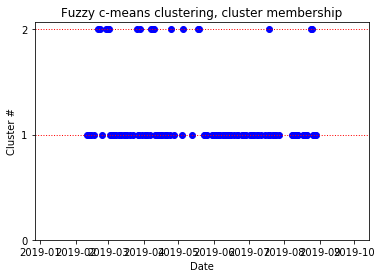

In [8]:
import skfuzzy as fuzz

counts = daily_sum['Count'].to_numpy()
add1row=np.ones(len(counts)) # add a new row to create a 2-dimensional array for input
alldata = np.vstack((counts, add1row))
center, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(alldata, c=2, m=2,
                                                   error=0.005, maxiter=1000, init=None)
cluster_membership = np.argmax(u, axis=0)
fuzz_result=pd.concat([result, pd.Series(cluster_membership, name='fuzz_cluster')], axis=1)
fuzz_result['fuzz_cluster'] = fuzz_result['fuzz_cluster'] + 1 # make to be cluster 1 and 2

## Visualize the date clusters
plt.scatter('Date', 'fuzz_cluster', data=fuzz_result, c='blue')
plt.yticks(np.arange(0, 3, 1))
plt.axhline(y=1, color='red', linestyle=':', linewidth=1)
plt.axhline(y=2, color='red', linestyle=':', linewidth=1)
plt.title('Fuzzy c-means clustering, cluster membership')
plt.xlabel('Date')
plt.ylabel('Cluster #')
plt.show()

Also the Daily Count at each day has been plotted and the red dots belong to **Cluster 1 (non-productive)** and the blue dots are under the **Cluster 2 (productive)**. The cluster center are shown as below. We can tell the centers for the two clusters are lower (smaller) than the ones we obtained from K-means method. 

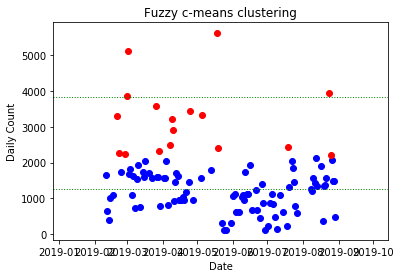

Fuzzy Cluster 1 center is:  1125.5418153881753
Fuzzy Cluster 2 center is:  3196.145600057928


In [9]:
## Visualize the count clusters
mask1 = fuzz_result.fuzz_cluster == 1
mask2 = fuzz_result.fuzz_cluster == 2
plt.scatter(fuzz_result.Date[mask1], fuzz_result.Count[mask1], c='blue')
plt.scatter(fuzz_result.Date[mask2], fuzz_result.Count[mask2], c='red')
plt.axhline(y=kmeans.cluster_centers_[0], color='green', linestyle=':', linewidth=1)
plt.axhline(y=kmeans.cluster_centers_[1], color='green', linestyle=':', linewidth=1)
plt.title('Fuzzy c-means clustering')
plt.xlabel('Date')
plt.ylabel('Daily Count')
plt.show()

print('Fuzzy Cluster 1 center is: ', center[0][0])
print('Fuzzy Cluster 2 center is: ', center[1][0])